In [50]:
base_path = 'IR-Newspapers-files\\IR-files'

labels_list = {'A-J' : 0, 'BBC' : 1, 'J-P' : 2, 'NY-T' : 3}

In [51]:
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity


def apply_kmeans(X, y_true, name):
    # Apply KMeans clustering
    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(X)
    kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
    y_pred_kmeans = kmeans.fit_predict(similarity_matrix)

    # Evaluate the clustering results
    precision = precision_score(y_true, y_pred_kmeans, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred_kmeans, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred_kmeans, average='macro', zero_division=1)
    accuracy = accuracy_score(y_true, y_pred_kmeans)
    # show numeric and visual results

    print(f"{name} results:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")

    tsne = TSNE(n_components=2, random_state=42)
    embedding_tsne = tsne.fit_transform(X)

    distinct_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#ff7f00']
    cmap = ListedColormap(distinct_colors[:len(set(y_pred_kmeans))])

    plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=y_pred_kmeans, cmap=cmap, s=10)
    plt.title(f'{name} Clustering')



    # Add legend with cluster labels
    cluster_labels = (labels_list.keys())
    handles = [plt.Line2D([0], [0], marker='o', color=distinct_colors[i % len(distinct_colors)], linestyle='', markersize=8, label=label)
               for i, label in enumerate(cluster_labels)]
    plt.legend(handles=handles, title="Clusters")

    plt.show()




In [52]:
import pandas as pd
import os

def apply_to_all_matrices(classifier):
    for dir in os.listdir(base_path):
        if dir == 'TF-IDF':
            clean_matrices = []
            lemma_matrices = []
            for file in sorted(os.listdir(f'{base_path}\\{dir}')):
                if 'clean' in file:
                    clean_matrices.append(pd.read_excel(f'{base_path}\\{dir}\\{file}').drop(columns=['DocumentIndex']))
                elif 'lemma' in file:
                    lemma_matrices.append(pd.read_excel(f'{base_path}\\{dir}\\{file}').drop(columns=['DocumentIndex']))


            shapes = [i.shape[0] for i in clean_matrices]

            y = []
            for i, j in enumerate(shapes):
                y = y + [i] * j


            clean_df = pd.concat(clean_matrices, ignore_index=True)
            lemma_df = pd.concat(lemma_matrices, ignore_index=True)



            print(f'{"-"*20}TF-IDF clean{"-"*20}')
            classifier(clean_df, y,'TF-IDF clean')
            print(f'{"-"*20}TF-IDF lemma{"-"*20}')
            classifier(lemma_df, y, 'TF-IDF lemma')

        else:
            for matrix in os.listdir(f'{base_path}\\{dir}'):
                df = pd.read_csv(f'{base_path}\\{dir}\\{matrix}')

                y = df['Sheet'].map(labels_list)

                df.drop(['RowIndex', 'Sheet'], axis=1, inplace=True)


                print(f'{"-"*20}{matrix}{"-"*20}')
                classifier(df, y, matrix)

In [53]:
# apply_to_all_matrices(apply_kmeans)

In [54]:
from sklearn.cluster import DBSCAN
import numpy as np
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler


def calc_DBSCAN(X, y_true, name):
    # Standardize the data
    X_standardized = StandardScaler().fit_transform(X)

    # Calculate pairwise distances
    distances = pairwise_distances(X_standardized)

    # Construct the MST
    mst = minimum_spanning_tree(distances).toarray()  # Ensure dense array

    # Extract the largest edge weight as epsilon
    eps = np.max(mst[mst > 0])

    # Set min_samples as before
    n_clusters = 4
    average_samples_per_cluster = X.shape[0] / n_clusters
    min_samples = int(0.5 * average_samples_per_cluster)

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    dbscan_labels = dbscan.fit_predict(X_standardized)

    # Evaluate the clustering results for DBSCAN
    precision = precision_score(y_true, dbscan_labels, average='macro', zero_division=1)
    recall = recall_score(y_true, dbscan_labels, average='macro', zero_division=1)
    f1 = f1_score(y_true, dbscan_labels, average='macro', zero_division=1)
    accuracy = accuracy_score(y_true, dbscan_labels)

    print(f"{name} results:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")

    tsne = TSNE(n_components=2, random_state=42)
    embedding_tsne = tsne.fit_transform(X)

    distinct_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#ff7f00']
    cmap = ListedColormap(distinct_colors[:len(set(dbscan_labels))])

    plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=dbscan_labels, cmap=cmap, s=10)
    plt.title(f'{name} Clustering')



    # Add legend with cluster labels
    cluster_labels = labels_list.keys()
    handles = [plt.Line2D([0], [0], marker='o', color=distinct_colors[i % len(distinct_colors)], linestyle='', markersize=8, label=label)
               for i, label in enumerate(cluster_labels)]
    plt.legend(handles=handles, title="Clusters")

    plt.show()



In [55]:
# apply_to_all_matrices(calc_DBSCAN)

In [56]:
from sklearn.mixture import GaussianMixture


def calc_mixture_of_gaussian(X, y_true, name):
    n_components = 4
    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(X)
    gm = GaussianMixture(n_components=n_components, random_state=0).fit(similarity_matrix)

    # Predicted labels from the GMM
    y_pred_gm = gm.predict(similarity_matrix)

    # Evaluate the clustering results for DBSCAN
    precision = precision_score(y_true, y_pred_gm, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred_gm, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred_gm, average='macro', zero_division=1)
    accuracy = accuracy_score(y_true, y_pred_gm)

    print(f"{name} results:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")

    tsne = TSNE(n_components=2, random_state=42)
    embedding_tsne = tsne.fit_transform(X)

    distinct_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#ff7f00']
    cmap = ListedColormap(distinct_colors[:len(set(y_pred_gm))])

    plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=y_pred_gm, cmap=cmap, s=10)
    plt.title(f'{name} Clustering')



    # Add legend with cluster labels
    cluster_labels = labels_list.keys()
    handles = [plt.Line2D([0], [0], marker='o', color=distinct_colors[i % len(distinct_colors)], linestyle='', markersize=8, label=label)
               for i, label in enumerate(cluster_labels)]
    plt.legend(handles=handles, title="Clusters")

    plt.show()

--------------------bert_withIDF.csv--------------------
bert_withIDF.csv results:
Precision: 0.26562527592694474
Recall: 0.1556761268781302
F1 Score: 0.18547280837481966
Accuracy: 0.15899403239556692


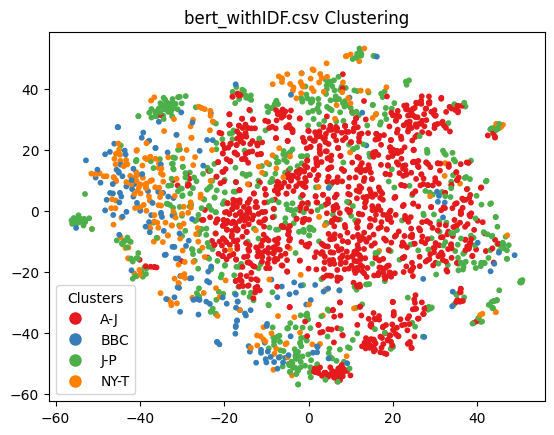

--------------------bert_withoutIDF.csv--------------------
bert_withoutIDF.csv results:
Precision: 0.037903893463453825
Recall: 0.0322129170961925
F1 Score: 0.03365435851458565
Accuracy: 0.032821824381926684


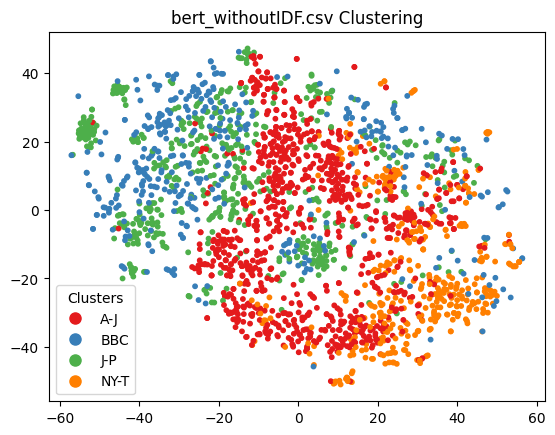

--------------------sbert_vectors.csv--------------------
sbert_vectors.csv results:
Precision: 0.3436620840880762
Recall: 0.3093467862344953
F1 Score: 0.3040740701519747
Accuracy: 0.31287297527706737


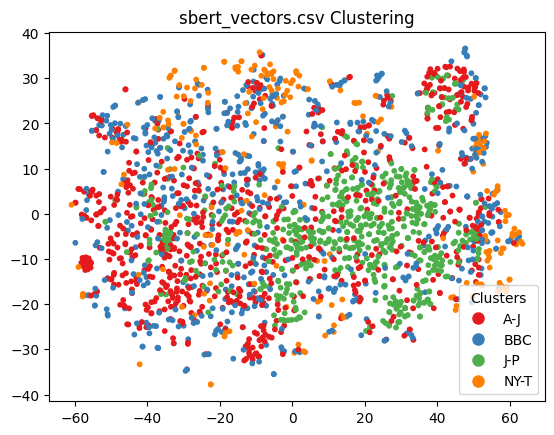

--------------------doc2vec_vectors.csv--------------------
doc2vec_vectors.csv results:
Precision: 0.39943855350027835
Recall: 0.35237235100395015
F1 Score: 0.3725136754564058
Accuracy: 0.35720375106564367


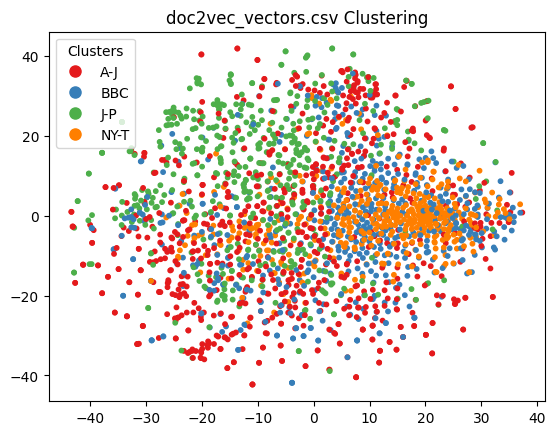

--------------------glove_clean_withIDF_withoutStopWords.csv--------------------
glove_clean_withIDF_withoutStopWords.csv results:
Precision: 0.11269536591727311
Recall: 0.13446667335662654
F1 Score: 0.11553491347691974
Accuracy: 0.13725490196078433


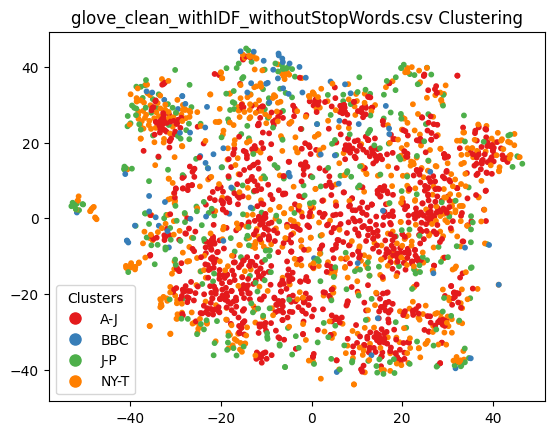

--------------------glove_clean_withIDF_withStopWords.csv--------------------
glove_clean_withIDF_withStopWords.csv results:
Precision: 0.20918081905618593
Recall: 0.1778381394613366
F1 Score: 0.1802349958803976
Accuracy: 0.1794543904518329


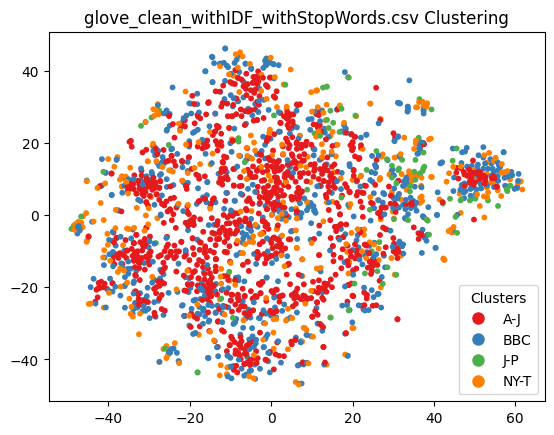

--------------------glove_clean_withoutIdf_withoutStopWords.csv--------------------
glove_clean_withoutIdf_withoutStopWords.csv results:
Precision: 0.10948259347119889
Recall: 0.13901964719584248
F1 Score: 0.1146226328709037
Accuracy: 0.14194373401534527


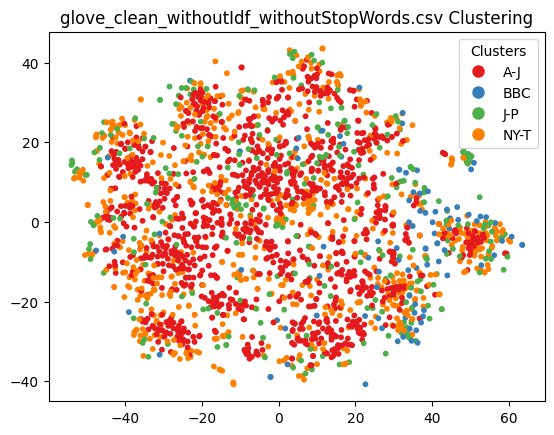

--------------------glove_clean_withoutIdf_withStopWords.csv--------------------
glove_clean_withoutIdf_withStopWords.csv results:
Precision: 0.053937235301769575
Recall: 0.07766739343958207
F1 Score: 0.06137094199857679
Accuracy: 0.0792838874680307


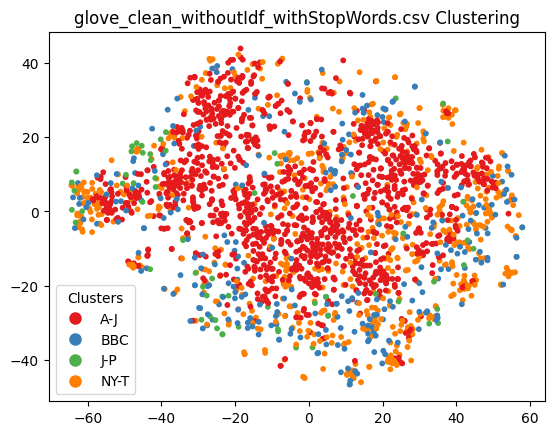

--------------------glove_lemma_withIDF_withoutStopWords.csv--------------------
glove_lemma_withIDF_withoutStopWords.csv results:
Precision: 0.10976778086412599
Recall: 0.1307104129225698
F1 Score: 0.11390668288717534
Accuracy: 0.13341858482523444


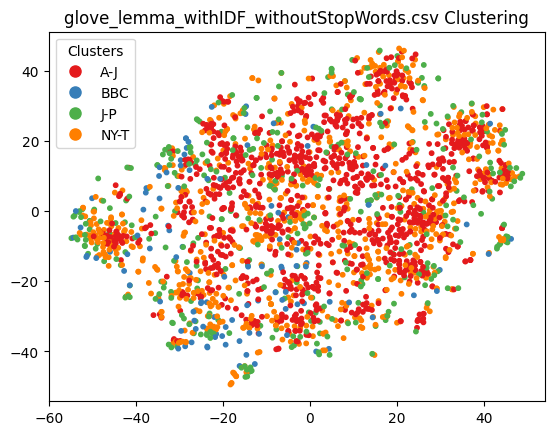

--------------------glove_lemma_withIDF_withStopWords.csv--------------------
glove_lemma_withIDF_withStopWords.csv results:
Precision: 0.23170857015101182
Recall: 0.21501759155362155
F1 Score: 0.21246560155038557
Accuracy: 0.2195225916453538


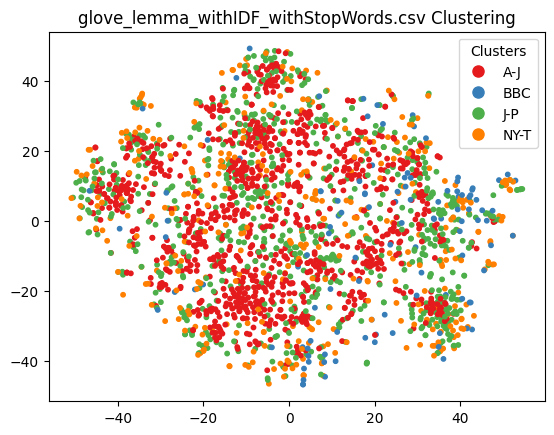

--------------------glove_lemma_withoutIdf_withoutStopWords.csv--------------------
glove_lemma_withoutIdf_withoutStopWords.csv results:
Precision: 0.3109486506477872
Recall: 0.14903634168666052
F1 Score: 0.13923868843063206
Accuracy: 0.15217391304347827


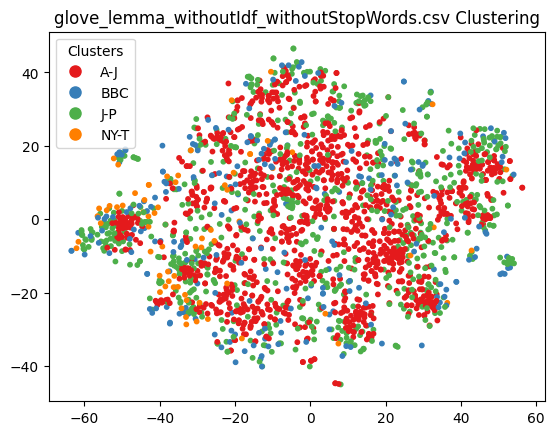

--------------------glove_lemma_withoutIdf_withStopWords.csv--------------------
glove_lemma_withoutIdf_withStopWords.csv results:
Precision: 0.06480116013996781
Recall: 0.08768408793040008
F1 Score: 0.0700473282777984
Accuracy: 0.08951406649616368


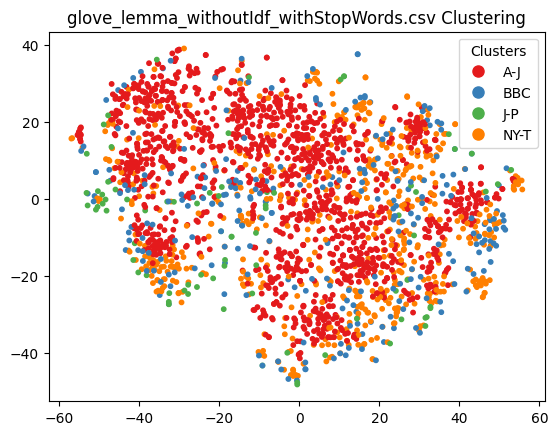

--------------------TF-IDF clean--------------------
TF-IDF clean results:
Precision: 0.04930728229743722
Recall: 0.04264697385746128
F1 Score: 0.045683622879497024
Accuracy: 0.043478260869565216


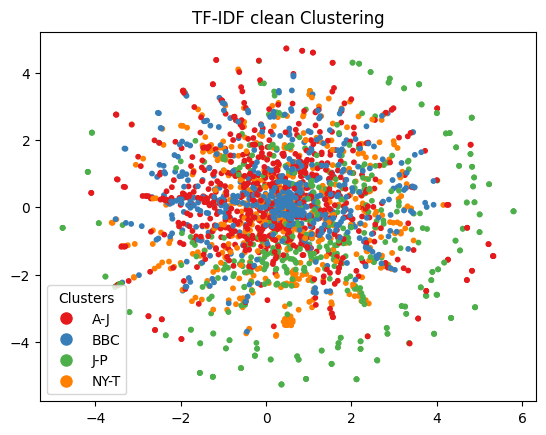

--------------------TF-IDF lemma--------------------
TF-IDF lemma results:
Precision: 0.3232234767061468
Recall: 0.31829764847909847
F1 Score: 0.31932843075178596
Accuracy: 0.32395566922421143


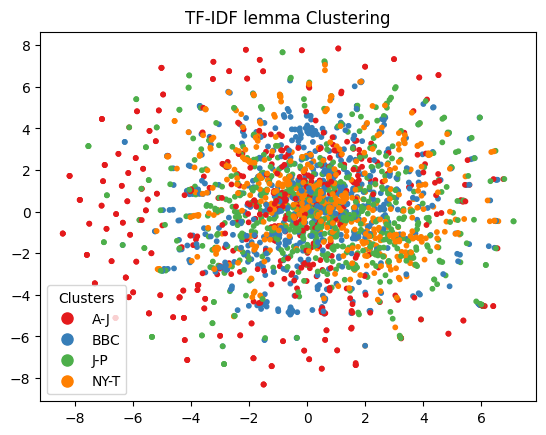

--------------------w2v_clean_withIDF_withoutStopWords.csv--------------------
w2v_clean_withIDF_withoutStopWords.csv results:
Precision: 0.2705802851359088
Recall: 0.31469115191986646
F1 Score: 0.28559811767872995
Accuracy: 0.3213981244671782


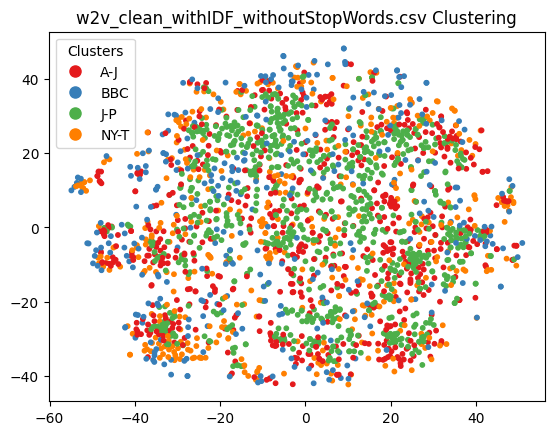

--------------------w2v_clean_withIDF_withStopWords.csv--------------------
w2v_clean_withIDF_withStopWords.csv results:
Precision: 0.16255317137661635
Recall: 0.18929317532864426
F1 Score: 0.17319467040633596
Accuracy: 0.19309462915601022


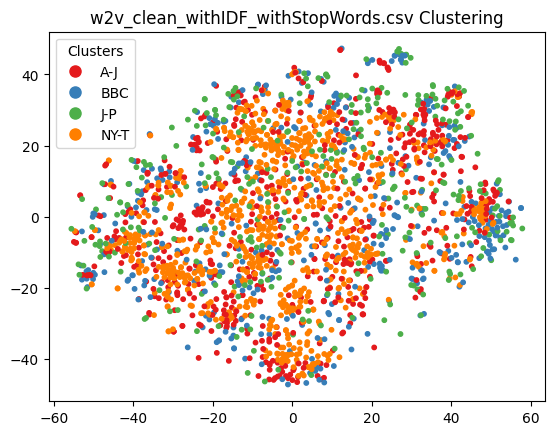

--------------------w2v_clean_withoutIdf_withoutStopWords.csv--------------------
w2v_clean_withoutIdf_withoutStopWords.csv results:
Precision: 0.22015502283445165
Recall: 0.18614357262103506
F1 Score: 0.19655110803593145
Accuracy: 0.19011082693947143


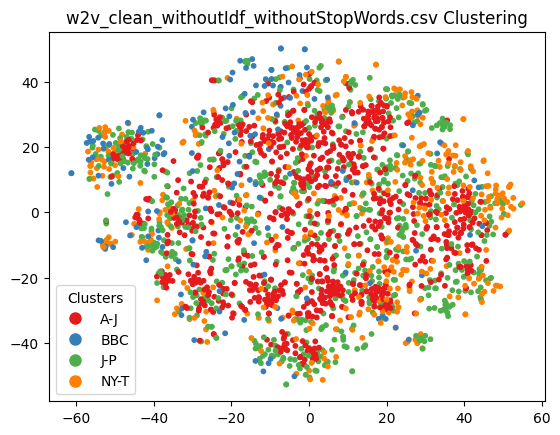

--------------------w2v_clean_withoutIdf_withStopWords.csv--------------------
w2v_clean_withoutIdf_withStopWords.csv results:
Precision: 0.4905278834249094
Recall: 0.5075125208681135
F1 Score: 0.4617437885911769
Accuracy: 0.5183290707587382


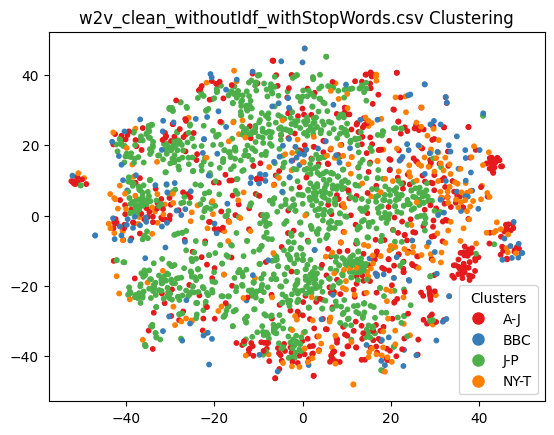

--------------------w2v_lemma_withIDF_withoutStopWords.csv--------------------
w2v_lemma_withIDF_withoutStopWords.csv results:
Precision: 0.044922998243940415
Recall: 0.04006677796327213
F1 Score: 0.041616439901701004
Accuracy: 0.04092071611253197


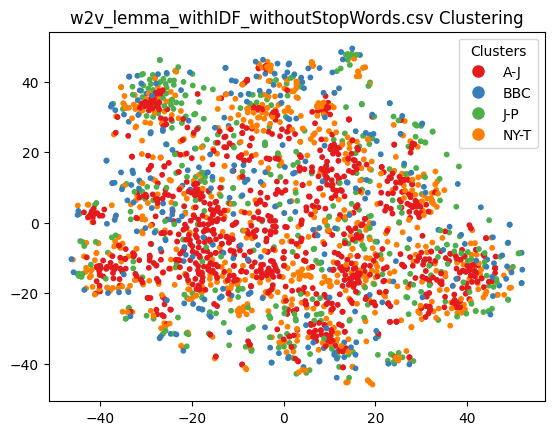

--------------------w2v_lemma_withIDF_withStopWords.csv--------------------
w2v_lemma_withIDF_withStopWords.csv results:
Precision: 0.1668983465779535
Recall: 0.1464941569282137
F1 Score: 0.15378063854913077
Accuracy: 0.149616368286445


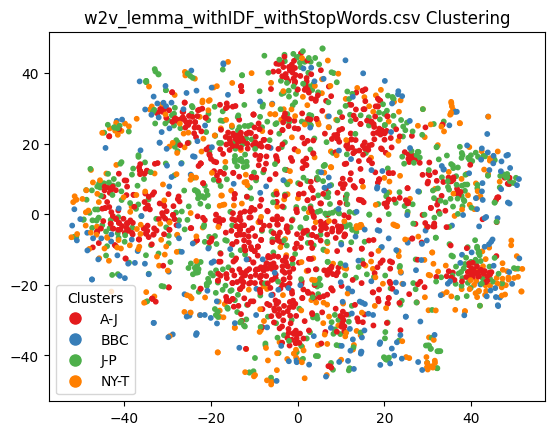

--------------------w2v_lemma_withoutIdf_withoutStopWords.csv--------------------
w2v_lemma_withoutIdf_withoutStopWords.csv results:
Precision: 0.045766909699545694
Recall: 0.04590984974958264
F1 Score: 0.044112122984688584
Accuracy: 0.04688832054560955


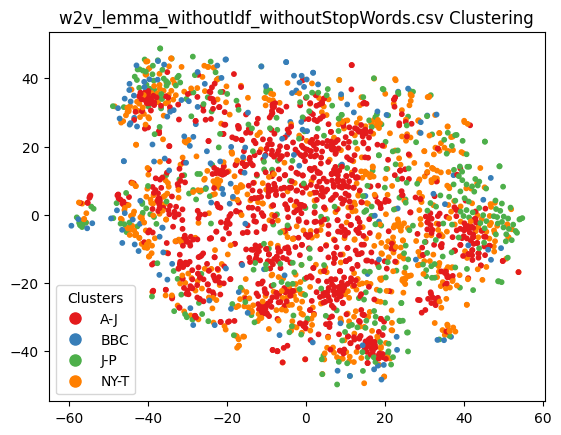

--------------------w2v_lemma_withoutIdf_withStopWords.csv--------------------
w2v_lemma_withoutIdf_withStopWords.csv results:
Precision: 0.29089267754416537
Recall: 0.12149043183691094
F1 Score: 0.15185398070102046
Accuracy: 0.12404092071611253


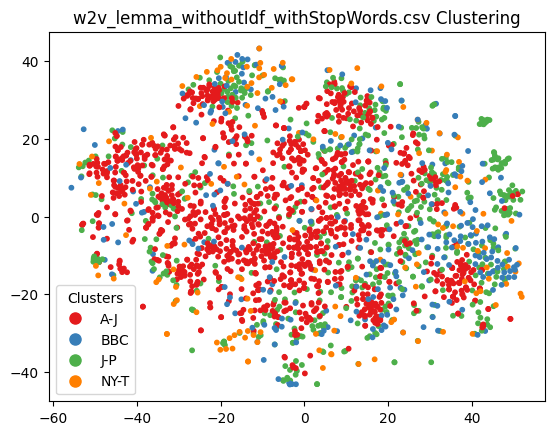

In [57]:
apply_to_all_matrices(calc_mixture_of_gaussian)

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

def evaluate_classifiers(X, y):
    """
    Evaluate classifiers using 10-fold cross-validation.

    Parameters:
    - X: Feature matrix.
    - y: Target labels.

    Returns:
    - None (prints mean accuracy for each classifier).
    """
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Define classifiers
    classifiers = {
        "Naive Bayes (NB)": GaussianNB(),
        "Support Vector Machine (SVM)": SVC(kernel='linear', random_state=42),
        "Logistic Regression (LoR)": LogisticRegression(random_state=42, max_iter=1000),
        "Random Forest (RF)": RandomForestClassifier(random_state=42, n_estimators=100),
    }

    # 10-fold cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Evaluate each classifier
    for name, clf in classifiers.items():
        scores = cross_val_score(clf, X_scaled, y, cv=cv, scoring='accuracy')
        print(f"{name}: Mean Accuracy = {scores.mean():.4f} ± {scores.std():.4f}")



